## Progetto d'esame di Simulazione Numerica 
## La Sociologia dei ratti
## Susanna Peretti, mat. 306186


In una popolazione di individui che interagiscono, ad esempio topi in gabbia, l'umore di un individuo può influenzare gli altri. Inoltre, un comportamento collettivo può emergere se le interazioni sono sufficientemente numerose, ad esempio se la densità dei ratti diventa sufficientemente grande.

I ratti partono da una posizione casuale in una griglia bidimensionale e con uno stato iniziale calmo. Ad ogni passo temporale i ratti:

1) Data una probabilità Pn, possono diventare nervosi

2) Uno alla volta, i ratti si spostano verso una delle direzioni disponibili

3) Controlla lo stato dei suoi vicini. Se un ratto calmo è vicino ad uno nervoso, diventa nervoso anche lui; se un ratto nervoso non ha vicini come lui, diventa calmo.

Per salvare le coordinate dei ratti posizionati e gestire i controlli viene utilizzato un dizionario che ha come chiavi tuple (x,y) (coordinate) e come valori interi 1 o 2 (stato del ratto). Considerando le densità fornite  da utilizzare nelle simulazione successive, la scelta del dizionario risulta essere più efficiente rispetto a salvare l'intera matrice per le seguenti ragioni:

1) Occupazione di memoria: salvare le coordinate dei ratti in un dizionario richiede meno memoria rispetto a salvare l'intera matrice, poiché solo le celle che contengono occupate vengono registrate e quelle vuote no

2) Modificabilità dei dati: modificare la posizione dei ratti in un dizionario è molto più semplice e veloce rispetto a modificare i valori di una matrice

3) Semplicità del codice: salvare le coordinate dei ratti in un dizionario può rendere il codice più semplice e comprensibile

La classe SociolocyOfRats implementa le seguenti funzioni:
- assign(): posiziona nRats assegnando casualmente le coordinate (x,y). Il numero dei ratti è calcolato utilizzando dimensione della matrice e densità fornite

- update(): funzione che rappresenta uno step temporale

- available(): calcola in quali direzioni un ratto ha la possibilità di spostarsi evitando che vada fuori dalla griglia. Su questa lista viene poi eseguito un controllo per rimuovere le caselle occupate da altri ratti, altrimenti finirebbero per sovrapporsi

- has_nervous_neighbor(): funzione per verificare se un ratto ha vicini nervosi

- measure(): calcola la frazione di ratti nervosi su ratti totali

- evolve(): accetta come parametri il numero Nt di passi di termalizzazione, il numero Nm di misurazioni e il numero Nd di passi di drop tra una misurazione e l'altra. La funzione restituisce la frazione fn di ratti nervosi calcolata in media durante la simulazione, la sua deviazione standard σn e anche il vettore delle misurazioni individuali effettuate

- draw(): mostra un grafico dello stato del reticolo, in cui i topi sono segnati come punti con colori diversi a seconda del loro stato


- gradients(): la funzione prende come input due liste, ds e fns, e calcola i coefficienti angolari (cioè le pendenze) delle rette che passano attraverso tutti i punti (ds[i], fns[i]).
Si utilizza il metodo lstsq della libreria numpy calcola la pendenza di ogni retta passante per la coppia di punti consecutivi nella lista ds e fns, e salva i risultati in una lista ms. Questa lista viene quindi restituita alla fine della funzione

- plot_animation(): la funzione crea l'animazione dell'evoluzione del lattice utilizzando la libreria matplotlib. 

In [32]:
# Import librerie
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import sys
import math
import random as rnd
from tqdm import tqdm
from scipy.stats import norm
from matplotlib import animation
from IPython.display import Image

# Definizione della classe
# Costruttore
class SociologyOfRats:
  # Definizione del costruttore
  def __init__(self, **args):
    """Parametri:
        L : int
          dimensione della matrice bidimenionale
        P : float
          densità dei topi da posizionare
        Pn : float
          probabilità che un ratto diventi nervoso spontaneamente"""
    self.L = int(args.get('L', 30))
    self.P = float(args.get('P', 0.01))
    self.Pn = float(args.get('Pn', 0.01))
    self.nRats = round(self.P * (self.L * self.L))
    self.lattice = {}
    self.age = 0

    # Assegnamento posizione iniziale random
    self.assign()

  # Definizione metodo 'assign'
  def assign(self):
    for i in range(self.nRats):
      while True:
        x = rnd.randint(0, (self.L-1))
        y = rnd.randint(0, (self.L-1))     
        if (x, y) not in self.lattice:
          self.lattice[(x,y)] = 1
          break

  # Definizione metodo 'update'
  def update(self):
    self.age += 1
    # 1) I ratti cambiano di umore in base alla probabilità Pn
    for (x,y) in self.lattice.keys():
      prob= rnd.randint(0,100)
      if prob <= (100*self.Pn) and (self.lattice[(x, y)] == 1):
        self.lattice.update({(x,y): 2})

    # 2) I ratti si spostano in una delle quattro direzioni
    work = self.lattice.copy()
    for (x,y) in work.keys():
      av = self.available(x,y)
      av2 = av.copy()
      for (i,j) in av2:
        if (i,j) in self.lattice.keys():
          av.remove((i,j))
      #Effettuo lo spostamento
      if (len(av) > 0):
        (i,j) = rnd.choice(av)
        #print('Ratto si sposta da [' + str(x) + ',' + str(y) + '] a [' + str(i) + ',' + str(j) + ']')
        self.lattice[(i,j)] = work.get((x,y))
        self.lattice.pop((x,y))

    # 3) I ratti calmi si innervosiscono se vicino a ratti nervosi
    work = self.lattice.copy()
    for (x,y) in work.keys():
      av = self.available(x,y)
      av2 = av.copy()
      for (i,j) in av2:
        if (i,j) not in self.lattice.keys():
          av.remove((i,j))
      if self.lattice[(x, y)] == 1 and self.has_nervous_neighbor(av):
        #print('Ratto_[' + str(x) + ',' + str(y) + '] diventa nervoso!')
        self.lattice.update({(x,y): 2})
      elif self.lattice[(x, y)] == 2 and (not self.has_nervous_neighbor(av)):
        self.lattice.update({(x,y): 1})
        #print('Ratto_[' + str(x) + ',' + str(y) + '] diventa calmo!') 

  def available(self, x, y):
    av = [(x+1,y),(x-1,y),(x,y+1),(x,y-1)]
    if x == self.L-1:
      av.remove((x+1,y))
    if x == 0:
      av.remove((x-1,y))
    if y == self.L-1:
      av.remove((x, y+1))
    if y == 0:
      av.remove((x,y-1))
    return av

  def has_nervous_neighbor(self, av):
    for (x,y) in av:
      if self.lattice[(x, y)] == 2:
        return True
    return False

  # Definizione metodo 'measure'
  def measure(self):
    nervous_rats = 0;
    for (x,y) in self.lattice.keys():
      if self.lattice.get((x,y)) == 2:
        nervous_rats += 1
    return nervous_rats / self.nRats

  # Definizione metodo 'evolve'
  def evolve(self,**args):
    """Parametri:
        Nt : int
          numero di thermalisation steps (default 10)
        Nm : int
          numero di measurement steps successivi (default 1)
        Nd : int
          intervallo tra misuramenti successivi (default 1)
        
        Return:
        - la frazione fn di ratti nervosi calcolata in media durante la simulazione
        - deviazione standard σn
        - vettore delle misurazioni individuali Nm effettuate"""
    Nt = int(args.get('Nt', 50))
    Nm = int(args.get('Nm', 100))
    Nd = int(args.get('Nd', 5))
    # Thermalisation steps
    for i in range(Nt):
      self.update()
    # Array di misurazioni di frazione media di ratti nervosi su totale
    meas = []
    for i in range(Nm):
      for j in range(Nd):
        self.update()
      meas.append(self.measure())
    # La funzione np.mean restituisce la media di questi valori, 
    # che è la frazione media di ratti nervosi durante la simulazione
    fn = np.mean(meas)
    # La funzione np.std restituisce la deviazione standard di questi valori, 
    # che fornisce una misura della dispersione intorno alla frazione media 
    # di ratti nervosi durante la simulazione.
    sigma = np.std(meas)
    return fn, sigma, meas

  # Definizione metodo 'draw'
  def draw(self):
    fig, ax = plt.subplots()
    for i in range(self.L):
      for j in range(self.L):
        if (i, j) in self.lattice:
          if self.lattice[(i, j)] == 1:
            ax.scatter(i, j, c='blue', marker='o')
          else:
            ax.scatter(i, j, c='red', marker='o')
        else:
          ax.scatter(i, j, c='white', marker='o')
    ax.set_xlim([0, self.L])
    ax.set_ylim([0, self.L])
    plt.show()

  # Definizione metodo 'gradients'
  def gradients(self, ds, fns):
    from numpy import ones,vstack
    from numpy.linalg import lstsq
    ms = []
    for i in range (len(fns)-1):
      points = [(ds[i] , fns[i]) , (ds[i+1] , fns[i+1])]
      x_coords, y_coords = zip(*points)
      A = vstack([x_coords,ones(len(x_coords))]).T
      m, c = lstsq(A, y_coords, rcond=None)[0]
      ms.append(m)
    ms.append(m)
    return ms

  # Definizione metodo 'plot_animation'
  def plot_animation(self, n):
    fig, ax = plt.subplots()
    self.evolve(Nt=50, Nm=10, Nd=1)
    x_coords = [x for x, y in self.lattice.keys()]
    y_coords = [y for x, y in self.lattice.keys()]
    colors = []
    for x, y in self.lattice.keys():
      if self.lattice[(x, y)] == 1:
        colors.append("blue")
      elif self.lattice[(x, y)] == 2:
        colors.append("red")
    scat = ax.scatter(x_coords, y_coords, c=colors)

    def animate(i):
      self.update()
      x_coords = [x for x, y in self.lattice.keys()]
      y_coords = [y for x, y in self.lattice.keys()]
      colors = []
      for x, y in self.lattice.keys():
        if self.lattice[(x, y)] == 1:
          colors.append("blue")
        elif self.lattice[(x, y)] == 2:
          colors.append("red")
      scat.set_offsets(np.c_[x_coords, y_coords])
      scat.set_color(colors)
      return [scat]

    anim_obj = animation.FuncAnimation(fig, animate, frames=n, interval=200, blit=True)
    #HTML(anim_obj.to_jshtml())
    #HTML(anim_obj.to_html5_video())
    anim_obj.save('animation.gif', writer='pillow')
    plt.close()
    display(Image(filename='animation.gif'))



## Assignment 1.1
Il codice seguente crea un'istanza della classe "SociologyOfRats" con un lattice di 30x30, una densità P=0.1 e una probabilità di diventare nervosi Pn=0.01. Quindi viene stampato il grafico 1 che rappresenta lo stato del lattice, con age=0, grazie al metodo draw()

Successivamente, viene invocato il metodo "evolve" sull'istanza di "SociologyOfRats" per eseguire l'evoluzione del sistema con parametri Nt, Nm e Nd. Infine, viene stampato il grafico 2 che rappresenta lo stato n-esimo del sistema

Assignment 1.1 - L = 30
Grafico 1: Age 0


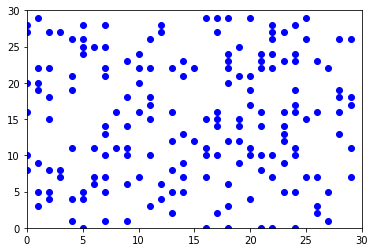

Grafico 2: Age 1550


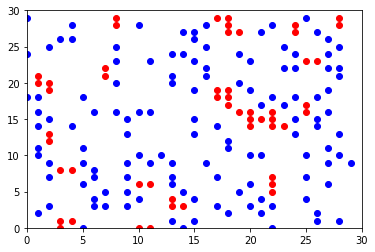

In [35]:
# ASSIGMENT 1.1
print('Assignment 1.1 - L = 30')
prova = SociologyOfRats(L=30, P=0.2, Pn=0.1)
print('Grafico 1: Age ' + str(prova.age))
prova.draw()
prova.evolve(Nt=50, Nm=50, Nd=30)
print('Grafico 2: Age ' + str(prova.age))
prova.draw()

## Assignment 1.2
Il codice seguente simula il sistema su una griglia di dimensione L=30 e la densità di ratti varia per n valori diversi [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5] 

Per ogni densità, la simulazione evolverà il sistema per Nt passi di termalizzazione, ottenendo Nm misure diverse in ogni passo temporale con una intervallo di Nd passi

Il Grafico 3 traccia la fn media misurata in funzione di p. Si dovrebbero osservare piccoli valori di fn per piccoli valori di p, quindi una transizione a valori maggiori all'aumentare di p e essere in grado di individuare approssimativamente il valore critico di densità pc

Il valore critico pc indica per quale densità il valore della frazione media di ratti nervosi su ratti totali cresce esponenzialmente. Per individuare questo punto il codice calcola la pendenza (inclinazione) della retta passante per ogni coppia di punti (densità, frazione media di ratti nervosi) rispetto alle predenti simulazioni. Si può notare dal grafico 3

Il grafico 4 mostra le pendenze calcolate in funzione delle varie densità. Il punto con la pendenza massima viene identificato e visualizzato come valore critico di densità. 

Assignment 1.2 - L = 30
p = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

Grafico 3


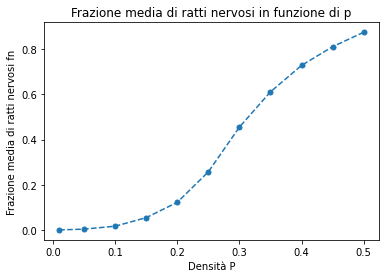


Grafico 4


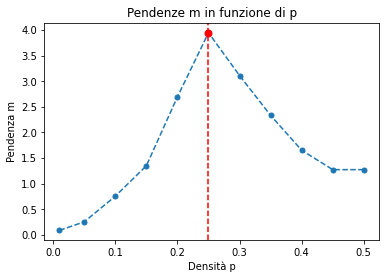


Critical value pc = 0.25


In [28]:
print('Assignment 1.2 - L = 30')
densities = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
fns = []
print('p = ' + str(densities))
print()

for d in densities:
  lattice = SociologyOfRats(L=30, P=d, Pn=0.01)
  fn, sigma, measurements = lattice.evolve(Nt=100, Nm=200, Nd=5)
  fns.append(fn)

print('Grafico 3')
plt.gca().set(title="Frazione media di ratti nervosi in funzione di p")  
plt.plot(densities, fns, marker='o', markersize=5, linestyle='--')
plt.xlabel('Densità p')
plt.ylabel('Frazione media di ratti nervosi fn')
plt.show()

ms = lattice.gradients(ds=densities, fns=fns)
max_index = ms.index(max(ms))
densities_highlight = [densities[max_index]]
ms_highlight = [ms[max_index]]
pc = densities[max_index]

print()
print('Grafico 4')
plt.gca().set(title="Pendenze m in funzione di p")
plt.plot(densities, ms, marker='o', markersize=5, linestyle='--')
plt.plot(densities_highlight, ms_highlight, marker='o', markersize=7, linestyle='--', color='red')
plt.axvline(pc, color='red', linestyle='--')

plt.xlabel('Densità p')
plt.ylabel('Pendenza m')
plt.show()
print()
print('Critical value pc = ' + str(pc))

## Assignment 2
Nel codice seguente per ogni densità p di [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5] viene creata un'istanza di SociologyOfRats con L = 50, P = densità corrente e Pn = 0.01. Viene quindi eseguita la funzione "evolve" su ogni istanza, che calcola la frazione media di ratti nervosi, la deviazione standard e le misurazioni individuali

Il Grafico 5 mostra la frazione di ratti media calcolata in funzione delle densità fornite

Il Grafico 6 mostra la deviazione standard in funzione delle densità fornite. 
La deviazione standard cresce per valori vicini a pc perché in questa zona la frazione di ratti nervosi su ratti totali è altamente variabile. Vicino a pc, la transizione da uno stato di stabilità a un altro stato di instabilità avviene rapidamente, il che comporta una maggiore varianza nei risultati

Assignment 2: L = 50
p = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

Grafico 5


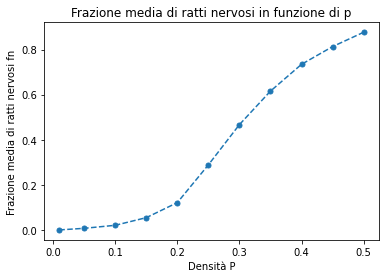


Grafico 6


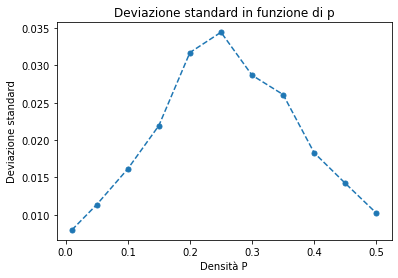

In [13]:
# ASSIGMENT 2
print('Assignment 2: L = 50')
print('p = ' + str(densities))
print()
fns = []
sigmas = []

for d in densities:
  lattice = SociologyOfRats(L=50, P=d, Pn=0.01)
  fn, sigma, measurements = lattice.evolve(Nt=100, Nm=200, Nd=5)
  fns.append(fn)
  sigmas.append(sigma)

print('Grafico 5')
plt.gca().set(title="Frazione media di ratti nervosi in funzione di p")
plt.plot(densities, fns, marker='o', markersize=5, linestyle='--')
plt.xlabel('Densità p')
plt.ylabel('Frazione media di ratti nervosi fn')
plt.show()

ms = lattice.gradients(ds=densities, fns=fns)
max_index = ms.index(max(ms))
densities_highlight = [densities[max_index]]
ms_highlight = [ms[max_index]]
pc = densities[max_index]

print()
print('Grafico 6')
plt.gca().set(title="Deviazione standard in funzione di p")
plt.plot(densities, sigmas, marker='o', markersize=5, linestyle='--')
plt.xlabel('Densità p')
plt.ylabel('Deviazione standard')
plt.show()

## Istogramma del valore critico pc
Dato che la posizione iniziale dei ratti è casuale e la probabilità di cambiare stato data una determinata probababilità, il valore critico pc non è affidabile su una sola esecuzione. Infatti eseguendo più simulazioni si può notare come il valore critico pc oscilli tra 0,2 e 0,3

Il codice seguente elabora un istogramma che mostri la distribuzione delle densità critiche calcolate su 50 simulazioni in una griglia di 50x50 e densità p [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]

L'istogramma, Grafico 7, mostra la distribuzione ottenuta e ci aiuta a capire se esiste un valore critico ben definito o identificare eventuali tendenze


100%|██████████| 50/50 [07:16<00:00,  8.74s/it]

Grafico 7


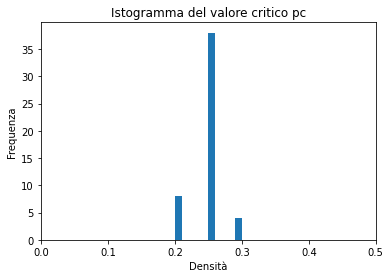

In [22]:
pcs = []
for i in tqdm( range(50)):
  fns = []  
  for d in densities:
    lattice = SociologyOfRats(L=50, P=d, Pn=0.01)
    fn, sigma, measurements = lattice.evolve(Nt=50, Nm=20, Nd=5)
    fns.append(fn)

  ms = lattice.gradients(ds=densities, fns=fns)

  max_index = ms.index(max(ms))
  densities_highlight = [densities[max_index]]
  ms_highlight = [ms[max_index]]
  pc = densities[max_index]
  pcs.append(pc)

print('Grafico 7')
plt.hist(pcs)
plt.xticks([0,0.1,0.2,0.3,0.4,0.5])
plt.gca().set(title='Istogramma del valore critico pc', ylabel='Frequenza', xlabel='Densità')
plt.show()
#Per 50 simulazioni Nt=50, Nm=20, Nd=5 tempo di esecuzione -> 8 min

## Assignment 3
Il codice seguente elabora un grafico che mostra l'autocorrelazione di una serie di misurazioni di frazioni di ratti nervosi su ratti totali per tre diversi valori di densità p:
- inferiore a pc
- vicina a pc
- superiore a pc

L'autocorrelazione viene calcolata utilizzando la funzione "correlate" di NumPy, che esegue una correlazione tra la serie di misurazioni e se stessa. Il risultato viene normalizzato dividendo per il prodotto scalare tra la serie di misurazioni e se stessa. 

L'autocorrelazione è una misura della correlazione tra i valori di una serie temporale in relazione a se stessi in momenti diversi. La sua forma può darci un'idea delle relazioni tra i valori di fn in momenti diversi. 

Se la funzione di autocorrelazione è alta, significa che i valori di fn sono altamente correlati ed è probabile che una variazione del valore di fn in un determinato momento sia seguita da una variazione simile in un momento successivo. Se la funzione di autocorrelazione è bassa, significa che i valori di fn non sono correlati e non c'è una relazione evidente tra i valori di fn in tempi consecutivi

Il Grafico 8 mostra i risultati dell'autocorrelazione, una per ogni valore di p

Assignment 3: L = 50
Grafico 8


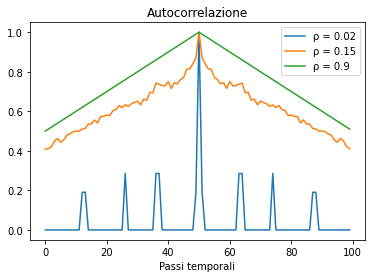

In [17]:
# Assigment 3
print('Assignment 3: L = 50')
p_values = [0.02, 0.15, 0.90]

for p in p_values:
  sim = SociologyOfRats(L=50, P=p, Pn=0.01)
  fn, sigma, m = sim.evolve(Nt=100, Nm=100, Nd=10)

  # Autocorrelazione
  ac = np.correlate(np.array(m), np.array(m), 'same',) / np.dot(np.array(m), np.array(m))
  np.seterr(invalid='ignore')
  plt.plot(ac, label="ρ = {}".format(p))

print('Grafico 8')
plt.legend()
plt.gca().set(title='Autocorrelazione',  xlabel='Passi temporali')
plt.show()

## Assignment 4
Il codice della funzione 'plot_animation' crea  un'animazione dell'evoluzione del modello. La funzione prende come input un intero n che rappresenta il numero di frame dell'animazione.

Il primo passo è creare lo stato iniziale del sistema e della griglia, considerando un controllo per lo stato del ratto.

La funzione animate() viene quindi utilizzata per aggiornare l'animazione, richiamando la funzione update(), ricalcolando le posizioni dei punti e i loro colori ogni volta che viene eseguita. L'animazione viene quindi salvata, come file "animation.gif" utilizzando la libreria 'Pillow', e visualizzata utilizzando il metodo display di IPython

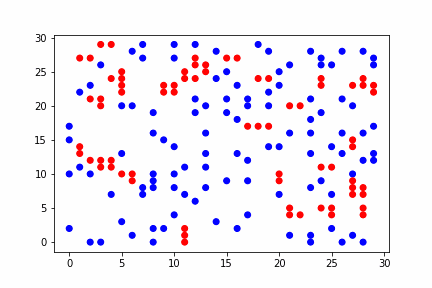

In [31]:
s = SociologyOfRats(L=30, P=0.2, Pn=0.2)
s.plot_animation(150)